In [1]:
from notebook_utils import setup

setup()

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from data_tools import load_parsed_data

In [3]:
from data_tools import load_crawled_terms
crawled_terms, crawled_hashtags, crawled_phrases = load_crawled_terms("../keywords-3nov.txt", split_hashtags=True)


In [4]:
DATAFRAME_DIR = "../data/dataframes/14-nov/"
#DATE = "2020-11-06"
DATE = "2020-11-13"

In [5]:
def load_or_create_cached_df(name, create_df):
    try:
        return pd.read_pickle(DATAFRAME_DIR + name)
    except:
        df = create_df()
        df.to_pickle(DATAFRAME_DIR + name)
        return df

In [6]:
def filter_df_by_date(df):
    min_date = pd.to_datetime(DATE)
    max_date = min_date + pd.DateOffset(days=1)
    timestamps = pd.to_datetime(df.timestamp).dt.tz_localize(None)
    return df[(timestamps > min_date) & (timestamps < max_date)]

df_tweets_by_date = load_or_create_cached_df(
    "df_tweets_{}.pickle".format(DATE),
    lambda: filter_df_by_date(pd.read_pickle(DATAFRAME_DIR + "df_recent_tweets.pickle"))
).set_index("datastore_id")

df_retweets_by_date = load_or_create_cached_df(
    "df_retweets_{}.pickle".format(DATE),
    lambda: filter_df_by_date(pd.read_pickle(DATAFRAME_DIR + "df_retweets.pickle"))
)

In [7]:
# build lookup table for retweets
from collections import defaultdict 
retweets_by_user = defaultdict(lambda: set())

for retweet in df_retweets_by_date.itertuples():
    retweets_by_user[retweet.user].add(retweet.retweeted)

In [8]:
def is_tweet_tagged_with_hashtag(tweet_hashtags, hashtag):
    for tweet_hashtag in tweet_hashtags:
        if tweet_hashtag.lower() == hashtag.lower():
            return True
    return False

def does_tweet_contain_any_term(tweet, terms):
    for term in terms:
        if term in tweet['full_text'].lower():
            return True
    return False

In [10]:
import gzip
import json
import os


hydrated_tweet_dir = '../data/coverage-test-us-pres/{}/hydrated/'.format(DATE)

line_count = 0
ferrara_tweet_count = 0
ferrara_retweet_count = 0
ferrara_matching_tweets = []
ferrara_matching_retweets = []

ferrara_ballot_tweet_ids = set()

only_ballot_tweet_ids = True

for filename in os.listdir(hydrated_tweet_dir):
    if filename.endswith(".jsonl.gz"):
        print("Processing {}".format(filename))
        with gzip.open(hydrated_tweet_dir + filename) as zipfile:
            for line in zipfile:
                tweet = json.loads(line)
                is_retweet = 'retweeted_status' in tweet
                match_array = ferrara_matching_retweets if is_retweet else ferrara_matching_tweets 
                
                line_count += 1
                if is_retweet:
                    ferrara_retweet_count += 1
                else:
                    ferrara_tweet_count += 1
                
                if (line_count % 25000 == 0):
                    print("Processed {} lines ({} tweets / {} retweets)".format(line_count, ferrara_tweet_count, ferrara_retweet_count))
                
                if ("ballot" in tweet["full_text"].lower()):
                    ferrara_ballot_tweet_ids.add(str(tweet["id"]))

                if (not only_ballot_tweet_ids):
                    tweet_hashtags = list(map(lambda x: x["text"].lower(), tweet["entities"]["hashtags"]))
                    for hashtag in crawled_hashtags:
                        if (is_tweet_tagged_with_hashtag(tweet_hashtags, hashtag)):
                            match_array.append(tweet)
                            break
                    if (does_tweet_contain_any_term(tweet, crawled_phrases)):
                        match_array.append(tweet)
        print("Total crawled terms found: {} tweets / {} retweets".format(len(ferrara_matching_tweets), len(ferrara_matching_retweets)))
        print("{} tweets containing 'ballot'".format(len(ferrara_ballot_tweet_ids)))

Processing us-presidential-tweet-id-2020-11-13-12.jsonl.gz
Processed 25000 lines (8016 tweets / 16984 retweets)
Processed 50000 lines (16170 tweets / 33830 retweets)
Processed 75000 lines (24407 tweets / 50593 retweets)
Processed 100000 lines (32586 tweets / 67414 retweets)
Processed 125000 lines (40671 tweets / 84329 retweets)
Processed 150000 lines (48534 tweets / 101466 retweets)
Total crawled terms found: 0 tweets / 0 retweets
6041 tweets containing 'ballot'
Processing us-presidential-tweet-id-2020-11-13-13.jsonl.gz
Processed 175000 lines (56603 tweets / 118397 retweets)
Processed 200000 lines (64850 tweets / 135150 retweets)
Processed 225000 lines (73047 tweets / 151953 retweets)
Processed 250000 lines (81105 tweets / 168895 retweets)
Processed 275000 lines (89208 tweets / 185792 retweets)
Processed 300000 lines (97000 tweets / 203000 retweets)
Processed 325000 lines (104928 tweets / 220072 retweets)
Total crawled terms found: 0 tweets / 0 retweets
12216 tweets containing 'ballot'

In [14]:
print(len(ferrara_matching_tweets))
print(len(ferrara_matching_retweets))
print(len(ferrara_ballot_tweet_ids))

0
0
141221


In [9]:
# Create a dataframe from Ferrara's tweets/retweets
df_ferrara_tweets_by_date = load_or_create_cached_df(
    "df_ferrara_tweets_{}.pickle".format(DATE),
    lambda: filter_df_by_date(pd.DataFrame([{
        "id": str(tweet["id"]), 
        "full_text": tweet["full_text"], 
        "timestamp": tweet["created_at"], 
        "hashtags": list(map(lambda x: x["text"].lower(), tweet["entities"]["hashtags"]))
    } for tweet in ferrara_matching_tweets]))
)

df_ferrara_retweets_by_date = load_or_create_cached_df(
    "df_ferrara_retweets_{}.pickle".format(DATE),
    lambda: filter_df_by_date(pd.DataFrame([{
        "user_id": str(retweet['user']['id']),
        "id": str(retweet["id"]), 
        "retweeted_id": str(retweet["retweeted_status"]["id"]), 
        "full_text": retweet["full_text"], 
        "timestamp": retweet["created_at"], 
        "hashtags": list(map(lambda x: x["text"].lower(), retweet["entities"]["hashtags"]))
    } for retweet in ferrara_matching_retweets]))
)

In [10]:
matching_tweets_by_term = defaultdict(lambda: set())
missing_tweets_by_term = defaultdict(lambda: set())

matching_retweets_by_term = defaultdict(lambda: set())
missing_retweets_by_term = defaultdict(lambda: set())
missing_tweets = []
missing_retweets = []

def add_tweet_to_term_stats(term_stats, tweet):
    for term in crawled_phrases:
        if term in tweet['full_text'].lower():
            term_stats[term].add(tweet['full_text'])
    for hashtag in crawled_hashtags:
        if (is_tweet_tagged_with_hashtag(tweet["hashtags"], hashtag)):
            term_stats['#' + hashtag].add(tweet['full_text'])

for i, tweet in df_ferrara_tweets_by_date.iterrows():
    if (tweet['id'] in df_tweets_by_date.index):
        add_tweet_to_term_stats(matching_tweets_by_term, tweet)
    else:
        missing_tweets.append(tweet)
        add_tweet_to_term_stats(missing_tweets_by_term, tweet)

for i, retweet in df_ferrara_retweets_by_date.iterrows():
    retweeted_id = retweet["retweeted_id"]
    user_id = retweet["user_id"]
    if (retweeted_id in retweets_by_user[user_id]):
        add_tweet_to_term_stats(matching_retweets_by_term, retweet)
    else:
        add_tweet_to_term_stats(missing_retweets_by_term, retweet)
        missing_retweets.append(retweet)

In [20]:
def print_missing_stats(ferrara_count, missing, matching_by_term, missing_by_term, stats_type):
    print("Missing {}/{} {} ({:,.1f}%)".format(
        len(missing),
        ferrara_count,
        stats_type,
        (len(missing) / ferrara_count) * 100
    ))
    
    for (term, missing_set) in sorted(missing_by_term.items(), key=lambda x: -len(x[1])):
        if (len(missing_set) > 0):
            total = (len(missing_set) + len(matching_by_term[term]))
            print("Missed {:,.1f}% for term: '{}' ({}/{})".format(
                (len(missing_set) / total) * 100,
                term,
                len(missing_set),
                total
            ))      

In [21]:
print_missing_stats(df_ferrara_tweets_by_date.shape[0], missing_tweets, matching_tweets_by_term, missing_tweets_by_term, 'tweets')

Missing 22532/33395 tweets (67.5%)
Missed 67.9% for term: 'voter fraud' (13344/19652)
Missed 67.0% for term: '#stopthesteal' (2693/4022)
Missed 65.9% for term: '#voterfraud' (2515/3817)
Missed 67.1% for term: 'election fraud' (2178/3247)
Missed 68.8% for term: '#electionfraud' (664/965)
Missed 65.3% for term: 'ballot harvesting' (516/790)
Missed 65.0% for term: 'ballot fraud' (417/642)
Missed 64.2% for term: 'election interference' (248/386)
Missed 77.7% for term: 'democrats cheat' (199/256)
Missed 77.5% for term: '#electioninterference' (131/169)
Missed 65.3% for term: '#ballotharvesting' (113/173)
Missed 57.8% for term: '#cheatingdemocrats' (85/147)
Missed 66.7% for term: '#voterfraudisreal' (70/105)
Missed 66.7% for term: 'cheating democrats' (58/87)
Missed 66.2% for term: 'stolen ballots' (49/74)
Missed 57.1% for term: 'election tampering' (44/77)
Missed 70.0% for term: '#ballotfraud' (35/50)
Missed 79.2% for term: '#democratvoterfraud' (19/24)
Missed 83.3% for term: '#stopvoterfra

In [22]:
print_missing_stats(df_ferrara_retweets_by_date.shape[0], missing_retweets, matching_retweets_by_term, missing_retweets_by_term, 'retweets')

Missing 93590/129791 retweets (72.1%)
Missed 65.0% for term: 'voter fraud' (5156/7938)
Missed 65.4% for term: '#voterfraud' (848/1297)
Missed 63.2% for term: 'election fraud' (841/1331)
Missed 67.4% for term: '#stopthesteal' (828/1228)
Missed 64.2% for term: 'ballot fraud' (188/293)
Missed 68.8% for term: 'ballot harvesting' (181/263)
Missed 67.5% for term: '#electionfraud' (141/209)
Missed 59.3% for term: 'election interference' (89/150)
Missed 72.1% for term: 'democrats cheat' (44/61)
Missed 64.6% for term: '#electioninterference' (31/48)
Missed 52.4% for term: '#ballotharvesting' (22/42)
Missed 55.0% for term: '#cheatingdemocrats' (22/40)
Missed 62.5% for term: '#voterfraudisreal' (20/32)
Missed 58.3% for term: 'stolen ballots' (14/24)
Missed 63.6% for term: 'election tampering' (14/22)
Missed 72.7% for term: 'discarded ballots' (8/11)
Missed 70.0% for term: 'cheating democrats' (7/10)
Missed 46.2% for term: '#ballotfraud' (6/13)
Missed 80.0% for term: '#stopvoterfraud' (4/5)
Missed

### Random sample of missing tweets/retweets



In [23]:
import numpy as np

print("-- Missing tweets --")
for tweet in np.random.choice(missing_tweets, 5):
    print("[{}]: {}".format(tweet['id'], tweet['full_text']))
    print()

print()

print("-- Missing retweets --")
for retweet in np.random.choice(missing_retweets, 5):
    print("[{}]: {}".format(retweet['id'], retweet['full_text']))
    print()

-- Missing tweets --


ValueError: a must be 1-dimensional

In [24]:
def filter_by_term(df, crawled_term):
    if (crawled_term[0] == '#'):
        hashtag = crawled_term[1:]
        m = df.apply(lambda x: hashtag.lower() in x['hashtags'], axis=1)
    else:
        m = df.apply(lambda x: term.lower() in x['full_text'].lower(), axis=1)
    return df[m]

In [25]:
def group_df_by_hour(df, column='timestamp'):
    grouped_by_hour = (pd.to_datetime(df[column])
        .dt.floor('H')
        .value_counts()
        .rename_axis('date')
        .reset_index(name='count')).sort_values(by=['date'])
    return grouped_by_hour.set_index('date')

def plot_hourly_coverage(our_df, matching_df, title):
    our_df_by_hour = group_df_by_hour(our_df)
    matching_df_by_hour = group_df_by_hour(matching_df)

    fig, ax = plt.subplots(figsize=(14,8), dpi=80)

    ax.plot(
        our_df_by_hour["count"], label="Our dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.plot(
        matching_df_by_hour["count"], label="Ferrara dataset", marker=".", linestyle="-", linewidth=0.5
    )

    ax.legend()

    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval = 2))

    ax.set_title("Coverage comparison on {} for '{}' (total={:,}/{:,})".format(DATE, title, len(our_df.index), len(matching_df.index)))

    return fig

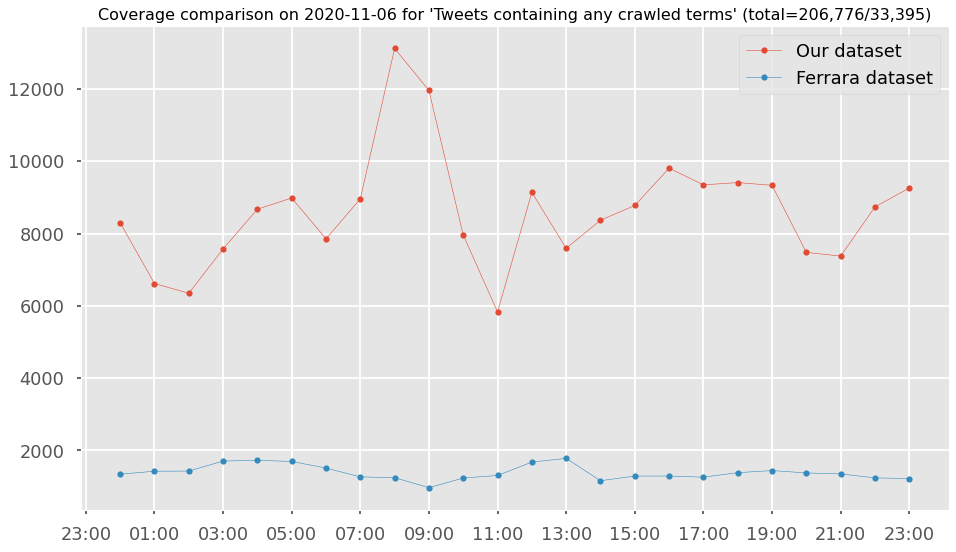

In [26]:
plot_hourly_coverage(df_tweets_by_date, df_ferrara_tweets_by_date, "Tweets containing any crawled terms")
None

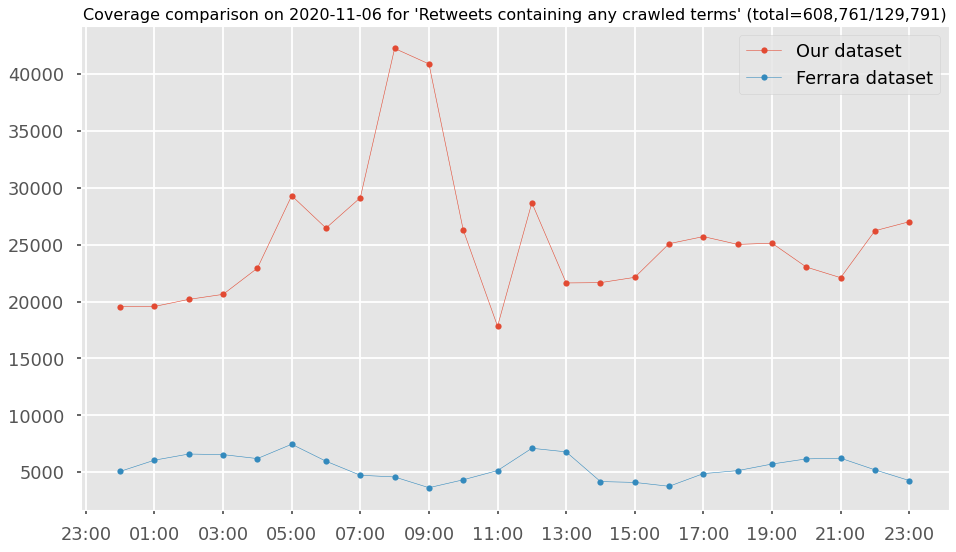

In [27]:
plot_hourly_coverage(df_retweets_by_date, df_ferrara_retweets_by_date, "Retweets containing any crawled terms")
None

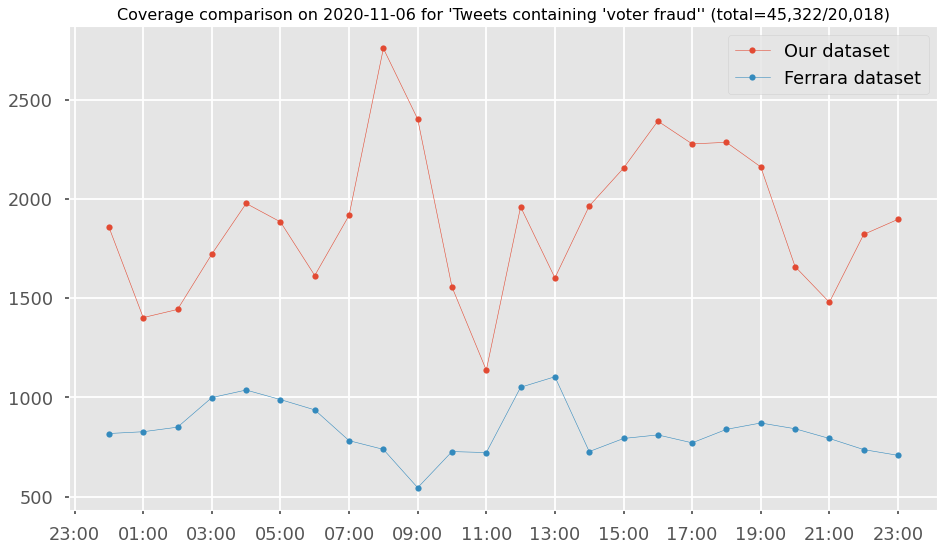

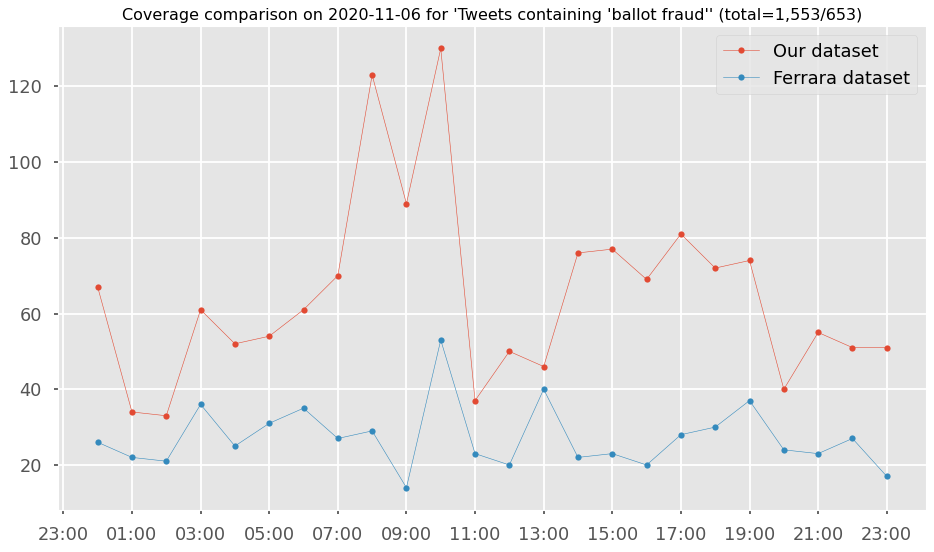

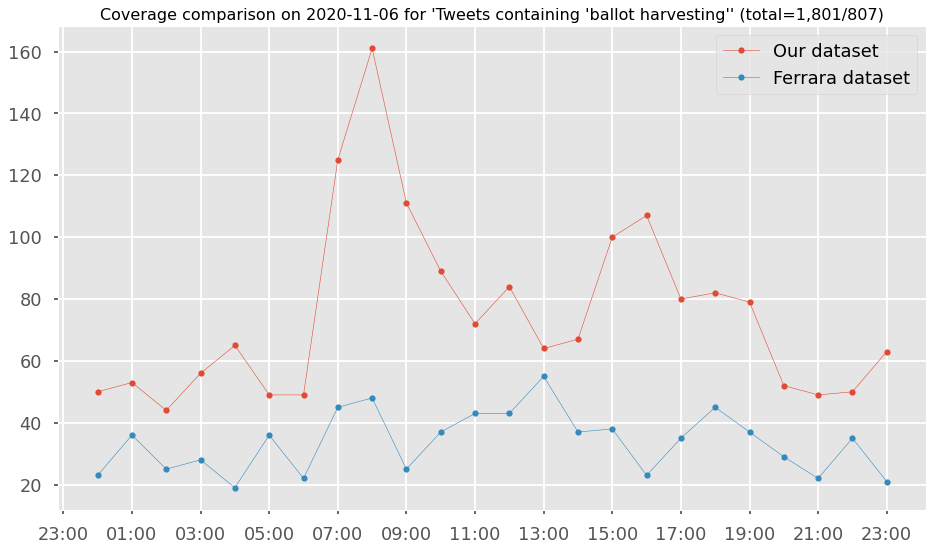

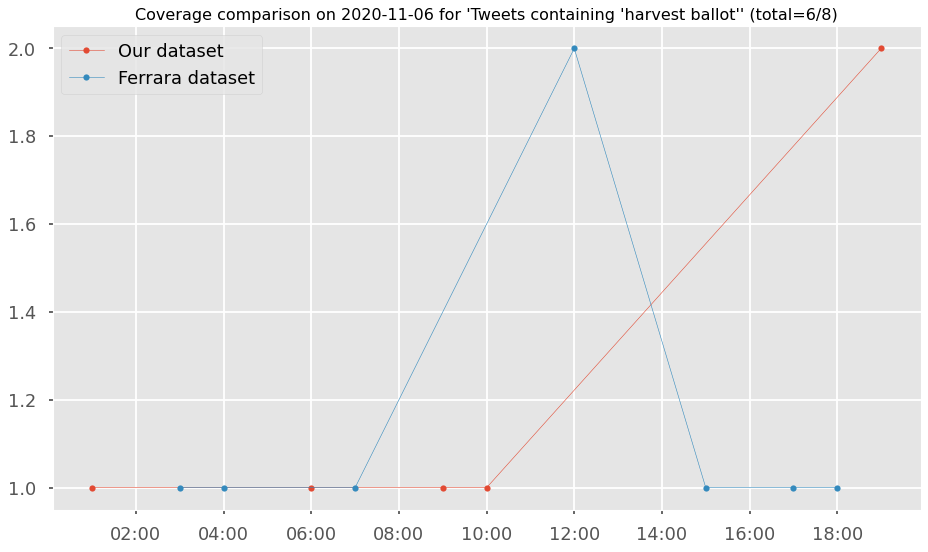

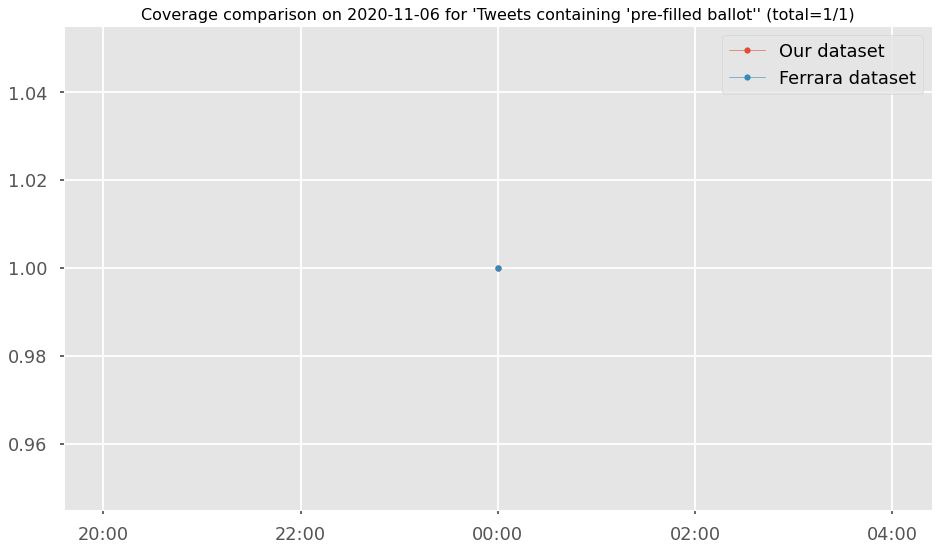

In [48]:
overlapping_terms = ["voter fraud", "ballot fraud", "ballot harvesting", "harvest ballot", "pre-filled ballot"]

for term in overlapping_terms:
    plot_hourly_coverage(df_tweets_by_date[df_tweets_by_date[term] == 1], filter_by_term(df_ferrara_tweets_by_date, term), "Tweets containing '{}'".format(term))


# Comparing Coverage for our Crawled Terms

In [33]:
crawled_term_coverage_comparison = []


for term in crawled_terms:
    if term in df_tweets_by_date.columns:
        our_tweets = df_tweets_by_date[df_tweets_by_date[term] == 1]
        ferrara_tweets = filter_by_term(df_ferrara_tweets_by_date, term)

        combined_ids = set(our_tweets.index.values).union(set(ferrara_tweets["id"].values))
        intersected_ids = set(our_tweets.index.values) & set(ferrara_tweets["id"].values)

        crawled_term_coverage_comparison.append({
            "term": term,
            "combined_tweet_count": len(combined_ids),
            "our_tweet_count": our_tweets.shape[0],
            "ferrara_tweet_count": ferrara_tweets.shape[0],
            "intersection": len(intersected_ids),
        })

In [34]:
crawled_term_coverage_comparison_df = pd.DataFrame(crawled_term_coverage_comparison).sort_values('combined_tweet_count', ascending=False).set_index("term")
crawled_term_coverage_comparison_df

,combined_tweet_count,our_tweet_count,ferrara_tweet_count,intersection
term,,,,
voter fraud,58696,45322,20018,6319
#stopthesteal,21361,18653,4232,1332
election fraud,16461,14261,3327,1073
#voterfraud,11370,8844,3998,1304
#electionfraud,4206,3541,1013,301
ballot harvesting,2318,1801,807,274
election interference,2133,1883,397,138
ballot fraud,1971,1553,653,225
#electioninterference,802,671,175,38


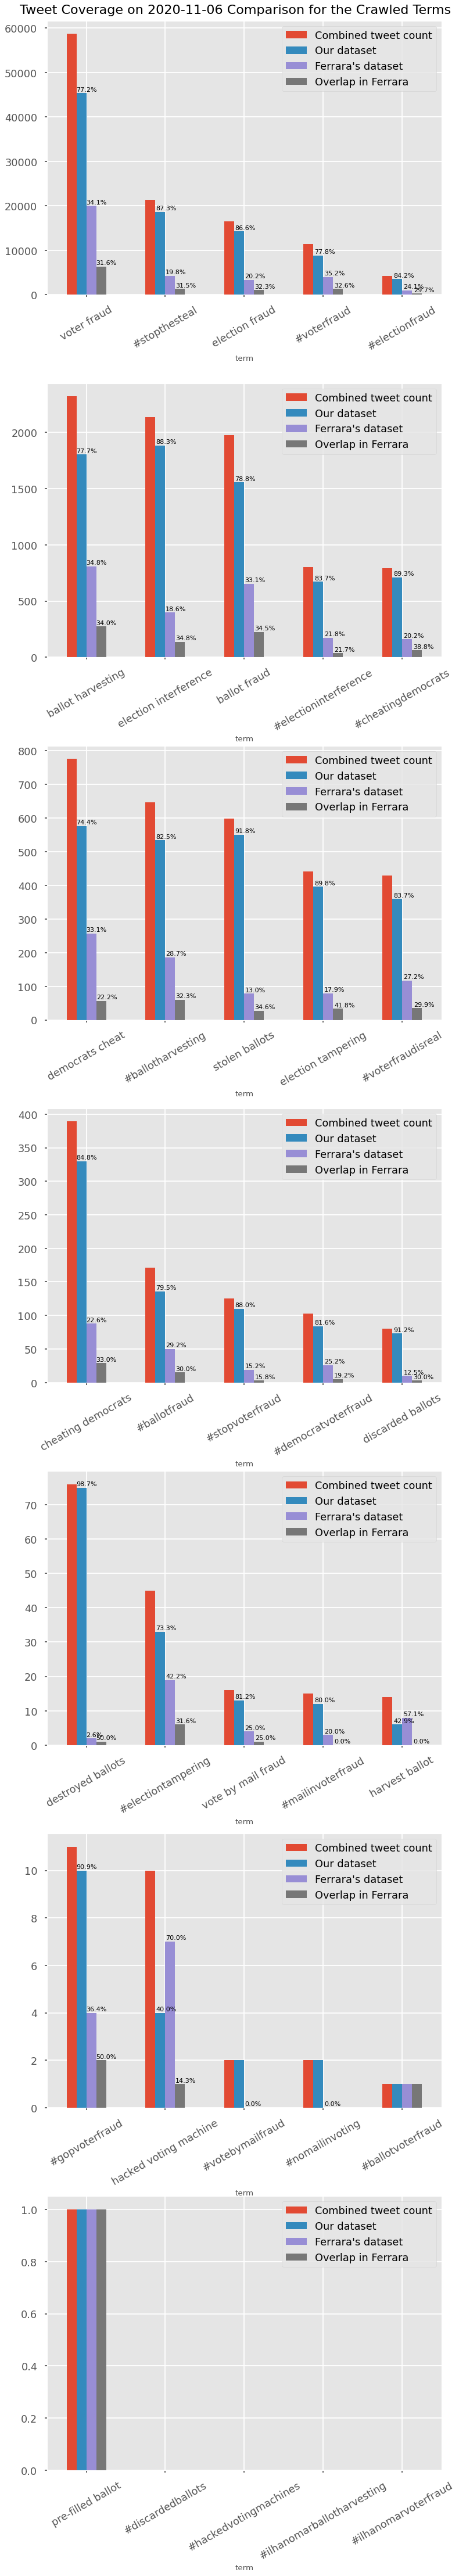

In [47]:
per_plot = 5
n_terms = crawled_term_coverage_comparison_df.shape[0]
n_plots = n_terms // per_plot
fig, axs = plt.subplots(n_plots, figsize=(12, n_plots * 8), dpi=80)
i = 0
fig.tight_layout(pad=10)
while i < n_terms:
    plot_df = crawled_term_coverage_comparison_df[i:i+per_plot]
    ax = axs[i // per_plot]
    plot_df.plot.bar(ax=ax, rot=30)

    for j, p in enumerate(ax.patches):
        row_index = j % plot_df.shape[0]
        feature_index = j // plot_df.shape[0]
        row = plot_df.iloc[row_index]
        if (plot_df.columns[feature_index] == "intersection"):
            total = row["ferrara_tweet_count"]
        else:
            total = row["combined_tweet_count"]
        
        patch_value = row.values[feature_index]

        if (patch_value != total):
            ax.annotate(
                "{:,.1f}%".format((patch_value / total) * 100), 
                (p.get_x() * 1.005, p.get_height() * 1.001),
                textcoords='offset points', xytext=(0, 3),
            )

    ax.legend(['Combined tweet count', 'Our dataset', 'Ferrara\'s dataset', 'Overlap in Ferrara'])
    i += per_plot

plt.suptitle("Tweet Coverage on {} Comparison for the Crawled Terms".format(DATE), fontsize=20)
plt.show()

# Reverse Coverage Test


In [21]:
term = "ballot"
our_ballot_tweet_ids = set()

for tweet_id, tweet_text in df_tweets_by_date[["text"]].itertuples():
    if term in tweet_text.lower():
        our_ballot_tweet_ids.add(tweet_id)

len(our_ballot_tweet_ids)

11796

In [22]:
diff = len(our_ballot_tweet_ids - ferrara_ballot_tweet_ids)

print("They are missing {:.2f}% of our ballot tweets".format((diff / len(our_ballot_tweet_ids)) * 100))

They are missing 70.58% of our ballot tweets
